### Attacks

Our implementation inludes three black-box patch attacks: Texture-based Patch Attack (TPA), MonoChrome Patch Attack (MPA) in our [paper](https://arxiv.org/abs/2004.05682); Metropolis-Hastings Attack (HPA) originally proposed in [paper](http://www.bmva.org/bmvc/2016/papers/paper137/index.html). Besides, we also implement the white-box patch attack: Adversarial Patch Attack (AP) orginally proposed in [paper](https://arxiv.org/abs/1712.09665).
You can add the path to the folder 'PatchAttack' in this repository to PYTHONPATH in your local system, and use 'PatchAttack' as a package. 

+ PatchAttack_tutorial.ipynb explains how to perform these attacks. The prerequisite of running this tutorial is to download the text file of [ImageNet_clsidx_to_labels](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) to the root directory of this repository. Please refer to the notebook for details. 

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.models as Models
import torchvision.transforms as Transforms
from PIL import Image
import urllib.request
import os


In [3]:
import PatchAttack.PatchAttack_attackers as PA
from PatchAttack import utils
from PatchAttack.PatchAttack_config import configure_PA

# Load model and images

In [4]:
with open(os.path.join('./imagenet1000_clsidx_to_labels.txt')) as file:
    lines = file.readlines()
human_readable_labels = [line.split("'")[1] for line in lines]

In [5]:
import json
from pathlib import Path
import torch

# 1) Load canonical ImageNet-1k mapping: index (0..999) -> [wnid, name]
#    Put imagenet_class_index.json next to the notebook, or give its full path.
with open("imagenet_class_index.json", "r") as f:
    idx_to_meta = json.load(f)

# 2) Invert to wnid -> index
WNID_TO_IDX = {meta[0]: int(k) for k, meta in idx_to_meta.items()}

def label_from_flat_filename(img_path: str) -> torch.LongTensor:
    """
    img_path like 'Images/n07749582_9050.JPEG'
    -> wnid 'n07749582' -> class index (0..999)
    """
    wnid = Path(img_path).stem.split('_')[0]  # take text before the first underscore
    if wnid not in WNID_TO_IDX:
        raise ValueError(f"WNID '{wnid}' not found in ImageNet mapping. Check filename/mapping.")
    idx = WNID_TO_IDX[wnid]
    return torch.LongTensor([idx])



In [6]:
import torch
torch.set_default_device('cuda')  # ensures *new* tensors default to CUDA (PyTorch 2.0+)
device = torch.device('cuda')
model = Models.resnet50(pretrained=True).to(device).eval()


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
preprocess = Transforms.Compose([
    Transforms.Resize(256),
    Transforms.CenterCrop(224),
    Transforms.ToTensor(),
    utils.data_agent.normalize,
])

In [19]:
image_dir = 'Images'
image_file = 'n01632777_10139.JPEG'
index = 0 # I specify this image corresponds to index 0, which relates to the dir to save the result
image= Image.open(os.path.join(image_dir, image_file))
label = label_from_flat_filename(os.path.join(image_dir, image_file))

In [20]:
input_tensor = preprocess(image).cuda()
label_tensor = torch.LongTensor([label]).cuda()
label_tensor

tensor([29], device='cuda:0')

pred: 29__axolotl, mud puppy, Ambystoma mexicanum


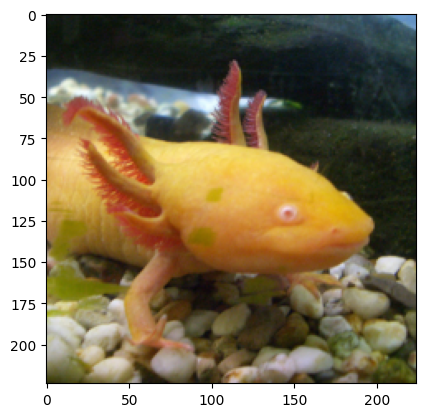

In [21]:
utils.data_agent.show_image_from_tensor(input_tensor, inv=True) # inv means inver normalize
with torch.no_grad():
    pred = model(input_tensor.unsqueeze(0)).argmax(dim=1).item()
    print('pred: {}__{}'.format(pred, human_readable_labels[pred]))

# TPA

In [ ]:
# configure PA_cfg
from PatchAttack.PatchAttack_config import configure_PA, PA_cfg

configure_PA(
    t_name='TextureDict_demo', # texture dictionary dir
    t_labels=np.arange(1000).tolist(), # all the labels in Dict, start from 0 and continuous
    target=True, # targetted or non-targetted attack
    n_occlu=1, # need to set to be 1 in TPA
    rl_batch=400, steps=40,
    TPA_n_agents=5, # maximum number of patches allowed in TPA
    lamda_area= 10 
)


In [23]:
import easydict
torch.serialization.add_safe_globals([easydict.EasyDict])  # allowlist the class
dir_title = 'PatchAttack_tutorial' # used to form the path where the results are saved
TPA = PA.TPA(dir_title)
adv_image, rcd_list = TPA.attack(
    model=model, 
    input_tensor=input_tensor, 
    label_tensor=label_tensor, 
    target=723, # For non targeted attack, use textures of a randonly chosen class
    input_name='{}'.format(index),
)


texture dictionary of label_723 is already built, loading...
target_723 | 30 texture images has been prepared!
not filtering the texture images
combos taken: 1 | pred: 29 | pred_confidence: 0.8203 | GT confidence: 0.8203 | target_confidence: 0.0000 | 
combos taken: 2 | pred: 29 | pred_confidence: 0.1331 | GT confidence: 0.1331 | target_confidence: 0.0079 | 
combos taken: 3 | pred: 300 | pred_confidence: 0.1141 | GT confidence: 0.0842 | target_confidence: 0.0526 | 
combos taken: 4 | pred: 723 | pred_confidence: 0.1653 | GT confidence: 0.0650 | target_confidence: 0.1653 | 
*** combos taken: 4 | non-target success: True | target success: True | queries: 36300 | 


In [24]:
combos = rcd_list[-1].combos[0] # all the actions RL agent has selected
area = TPA.calculate_area(adv_image, combos)
print('Area used: {:.4f}'.format(area))

Area used: 0.0235


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000211].


pred: 723__pinwheel


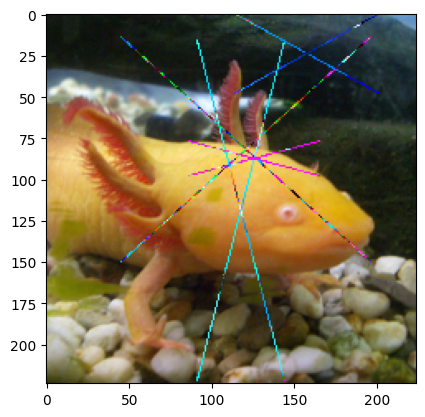

In [25]:
utils.data_agent.show_image_from_tensor(adv_image, inv=True)
with torch.no_grad():
    pred = model(adv_image.unsqueeze(0)).argmax(dim=1).item()
    print('pred: {}__{}'.format(pred, human_readable_labels[pred]))